# Fast Radio Burst Ray-tracing Catalogs

This Jupyter notebook is explaining how to load and plot the DM catalogs released with

Konietzka et al. 2025, Ray-tracing Fast Radio Bursts Through IllustrisTNG: Cosmological Dispersion Measures from Redshift 0 to 5.5.

If you use these DM catalogs, we ask you to cite Konietzka et al., 2025.

## Install basic packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

## Load data

Now we will import the continuous and full-sky catalog

NOTE:

The files Konietzka2025_DMmap_continuous_v1.hdf5 and Konietzka2025_DMmap_fullsky1_v1.hdf5 must be in the same directory as this Jupyter notebook.

If you have not downloaded the data yet, please do so first.

In [2]:
# continuous catalog
# This can take a few seconds

name_continuous = 'Konietzka2025_DMmap_continuous_v1.hdf5'
with h5py.File(name_continuous, 'r') as file:
    
    # load the data
    DM_continuous = file['DMvalues'][:]
    z_continuous  = file['redshifts'][:]
    

In [3]:
print('shape DM', DM_continuous.shape)
print('shape redshift', z_continuous.shape)


shape DM (550, 120000)
shape redshift (550,)


We have 550 redshift bins and 120000 lines of sight

In [4]:
# full-sky catalog
# This can take a few seconds

name_fullsky = 'Konietzka2025_DMmap_fullsky1_v1.hdf5'
with h5py.File(name_fullsky, 'r') as file:
    
    # load the data
    DM_fullsky = file['DMvalues'][:]
    z_fullsky  = file['redshifts'][:]

## Plot histograms

Now, we plot some histograms with the continuous catalog

To this end, we define the find_index function

find_index searches in the redshift data which idx in the DM data corresponds to the target redshift

In [5]:
def find_index(redshift, redshifts):
    """
    takes the target redshift and the redshifts array (e.g., z_continuous)
    returns index
    """
    index = np.where(np.round(redshifts,3)==np.round(redshift,3))[0][0]
    return index

In [6]:
# We find the index for redshift z = 1.
z_target = 1.0
index_1 = find_index(z_target, z_continuous)
print(index_1)

99


In [7]:
# Next, we output the DM at redshift z=1.0
DM_1 = DM_continuous[index_1, :]

(600.0, 1800.0)

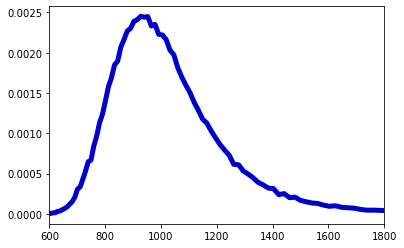

In [8]:
# plot single hist
plt.figure()

min_DM, max_DM = np.min(DM_1), np.max(DM_1)
log_bins = np.logspace(np.log10(min_DM), np.log10(max_DM), 200)
hist, bin_edges = np.histogram(DM_1, bins=log_bins, density=True)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

plt.plot(bin_centers, hist, c='mediumblue', linewidth=5)
plt.xlim(600, 1800)

(0.0, 0.016)

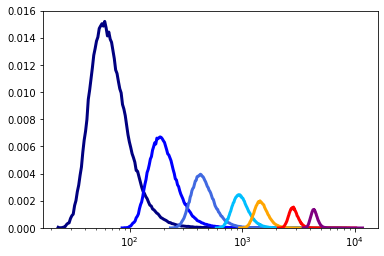

In [9]:
# plot several hists
plt.figure()

colors = ['navy', 'blue', 'royalblue', 'deepskyblue', 'orange', 'red', 'purple']
for idx, redshift in enumerate([0.1, 0.25, 0.5, 1.0, 1.5, 3.0, 5.0]):
    
    # find index
    index_z = find_index(redshift, z_continuous)
    
    # get DM
    DM_z = DM_continuous[index_z, :]
    
    min_DM, max_DM = np.min(DM_z), np.max(DM_z)
    log_bins = np.logspace(np.log10(min_DM), np.log10(max_DM), 200)
    hist, bin_edges = np.histogram(DM_z, bins=log_bins, density=True)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

    plt.plot(bin_centers, hist, c=colors[idx], linewidth=3)

plt.xscale('log')
plt.ylim(0, 0.016)

## Plot new functional form for cosmological DMs

For details see Konietzka et al. 2025, Ray-tracing Fast Radio Bursts Through IllustrisTNG: Cosmological Dispersion Measures from Redshift 0 to 5.5.

In [10]:
# import special functions
from scipy.special import gamma
from scipy.special import pbdv as paracylD

In [11]:
# PDF based on a modified-normal distribution with power-law tail

def PDF_Konietzka2025(x, mu, sigma):
    # fix shape parameters
    alpha = 1
    beta = 3.3
    nu = (beta-1)/alpha
    norm = np.log(mu/alpha) - mu**2/(4*alpha**2*sigma**2) - nu*np.log(mu/(alpha*sigma)) + np.log(gamma(nu)) + np.log(paracylD(-nu, -mu/(alpha*sigma))[0])
    return  np.exp(-((mu/x)**alpha - 1)**2 * mu**2/(2*alpha**2*sigma**2) - beta*np.log(x/mu) - norm)


In [12]:
# best fit parameters (determined with dynesty, see J. S. Speagle, 2019)
mu = 1031.96
sigma = 191.50


(600.0, 1800.0)

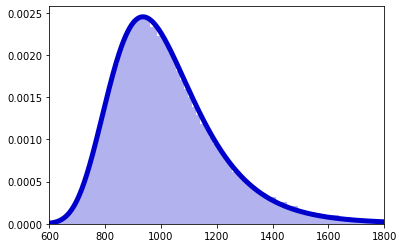

In [13]:
# plot single hist + best fit
plt.figure()

min_DM, max_DM = np.min(DM_1), np.max(DM_1)
log_bins = np.logspace(np.log10(min_DM), np.log10(max_DM), 200)
plt.hist(DM_1, color='mediumblue', bins=log_bins, alpha=0.3, density=True)

x = np.arange(500, 1900, 1)
plt.plot(x, PDF_Konietzka2025(x, mu, sigma), c='mediumblue', linewidth=5)

plt.xlim(600, 1800)

We see that the model provides a perfect fit 

## Plot the full-sky map

In [14]:
import matplotlib.colors as mcolors
import healpy as hp
from matplotlib.patches import Ellipse

In [15]:
# Define cmap
colors_blue = ['black', 'dodgerblue', 'lightskyblue', 'white']
n_bins = 1000
cmap_blue = mcolors.LinearSegmentedColormap.from_list('blue', colors_blue, N=n_bins)

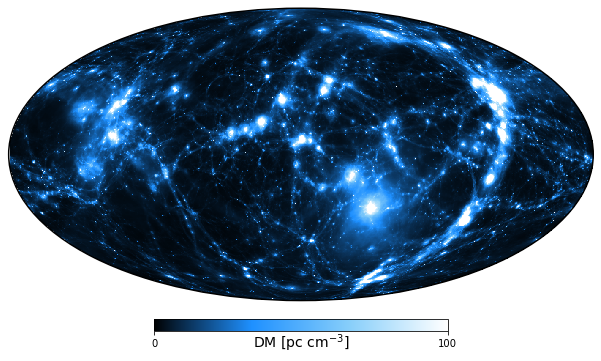

In [16]:

redshift_plot = 0.01
idx_plot = find_index(redshift_plot, z_fullsky)
DM_plot = DM_fullsky[idx_plot, :]

hp.mollview(DM_plot, unit=r'DM [pc cm$^{-3}$]', min=int(0), max=int(100), xsize=800, cmap=cmap_blue)
plt.gca().set_title('')

ax = plt.gca()
ellipse = Ellipse(xy=(0, 0), width=4, height=2, edgecolor='black', 
                  facecolor='none', linewidth=1.5, transform=ax.transData)
ax.add_patch(ellipse)

plt.show()

## Plot the DM-redshift relation

Lastly, we plot the DM-z relation

Text(0, 0.5, 'DM [pc cm$^{-3}$]')

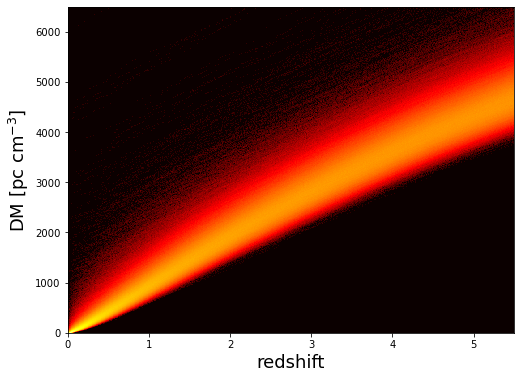

In [17]:
plt.figure(figsize=(8, 6))

x = np.repeat(z_continuous, DM_continuous.shape[1])
y = DM_continuous.flatten()

weights = np.array([1/DM_continuous.shape[1]]*len(x))
counts, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=[z_continuous.shape[0], 5*DM_continuous.shape[0]])
log_counts = np.log(counts + 10**(-5))
plt.pcolormesh(xedges, yedges, log_counts.T, cmap='hot', alpha=1)

plt.xlim(0, 5.5)
plt.ylim(0, 6500)

plt.xlabel(r'redshift', fontsize=18)
plt.ylabel(r'DM [pc cm$^{-3}$]', fontsize=18)